# Heuristic Bed Assignment using a Greedy Algorithm

This notebook implements a heuristic method to assign hospital beds based on predicted length of stay (LOS). Unlike mathematical programming methods (e.g., MILP), this greedy algorithm provides a fast and scalable approximation, especially useful for large-scale simulations.The goal is to:

- Quickly assign each patient to the first available bed
- Track occupancy over time
- Estimate the number of beds needed or unassigned patients due to limits


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict
import joblib
import time
import matplotlib.cm as cm

# Load the trained pipeline
pipeline = joblib.load(r"C:\CodigosGithub\Hospital_LOS_Prediction\models\xgb_final_pipeline.pkl")
print("Model pipeline loaded.")

# Load your full cleaned dataset (replace with full path if needed)
df_full = pd.read_csv(r"C:\CodigosGithub\Hospital_LOS_Prediction\data\hospital_cleaned.csv")


Model pipeline loaded.


In [3]:
# Simulate new patients
np.random.seed(42)
n_patients = 100
simulation_days = 60
n_beds = 100

categorical_features = [
    'age_group', 'gender', 'race', 'ethnicity',
    'type_of_admission', 'patient_disposition',
    'ccsr_diagnosis_description', 'apr_severity_of_illness_description',
    'apr_risk_of_mortality', 'apr_medical_surgical_description',
    'payment_typology_1', 'emergency_department_indicator'
]

# Sample patients and predict LOS
new_patients = df_full.sample(n=n_patients, random_state=123).copy()
new_patients['day_of_admission'] = np.random.randint(0, simulation_days, size=n_patients)
new_patients['predicted_los'] = np.ceil(
    pipeline.predict(new_patients[categorical_features])
).astype(int)

In [4]:
# Greedy bed assignment
beds = defaultdict(list)
assignments = []

# Sort patients by admission day to ensure a consistent allocation order
# This allows the greedy algorithm to simulate a real-time arrival process
patients_sorted = new_patients.sort_values(by='day_of_admission')

for idx, patient in patients_sorted.iterrows():
    assigned = False
    start = patient['day_of_admission']
    end = min(start + patient['predicted_los'], simulation_days)

    for bed_id in range(n_beds):
        overlaps = any(
            not (end <= s or start >= e) for s, e in beds[bed_id]
        )
        if not overlaps:
            beds[bed_id].append((start, end))
            assignments.append({
                'patient_id': idx,
                'bed_id': bed_id,
                'start': start,
                'end': end
            })
            assigned = True
            break

    if not assigned:
        assignments.append({
            'patient_id': idx,
            'bed_id': None,
            'start': start,
            'end': end
        })

assignments_df = pd.DataFrame(assignments)

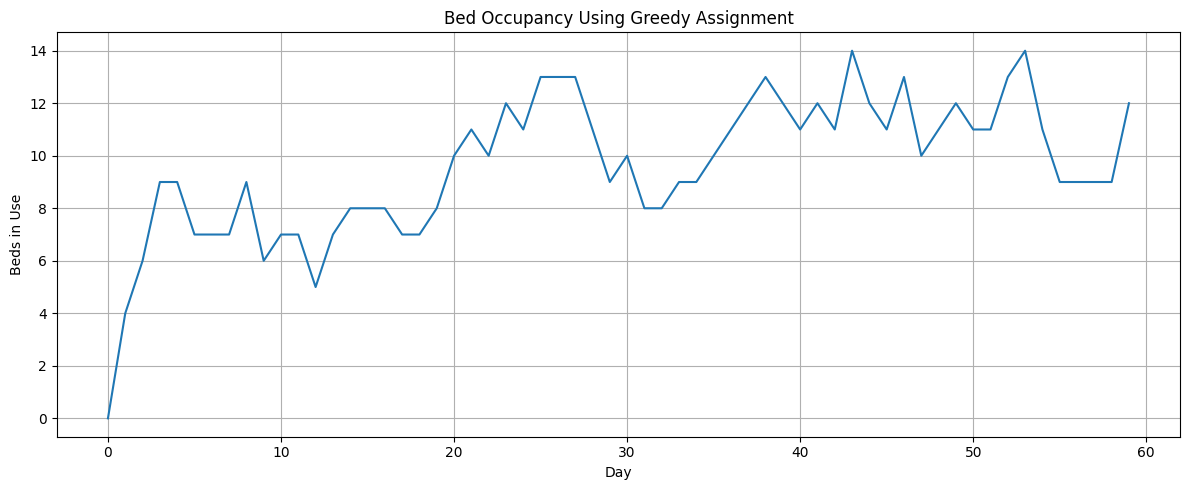

In [5]:
# Plot occupancy
bed_occupancy = np.zeros(simulation_days)
for _, row in assignments_df.dropna().iterrows():
    bed_occupancy[int(row['start']):int(row['end'])] += 1

plt.figure(figsize=(12, 5))
plt.plot(bed_occupancy)
plt.title("Bed Occupancy Using Greedy Assignment")
plt.xlabel("Day")
plt.ylabel("Beds in Use")
plt.grid(True)
plt.tight_layout()
plt.show()

In [6]:
# Results
total_assigned = assignments_df['bed_id'].notna().sum()
total_unassigned = assignments_df['bed_id'].isna().sum()
valid_assignments = assignments_df.dropna(subset=["bed_id"]).copy()
valid_assignments["bed_id"] = valid_assignments["bed_id"].astype(int)
total_beds = valid_assignments["bed_id"].nunique()
print(f"Patients assigned to beds: {total_assigned}/{n_patients}")
print(f"Patients unassigned due to capacity limits: {total_unassigned}")
print(f"Number of beds needed: {len(beds)}")

Patients assigned to beds: 100/100
Patients unassigned due to capacity limits: 0
Number of beds needed: 14


The following Gantt chart shows the bed occupancy across the simulation period. Each horizontal line represents one bed, with colored segments indicating assigned patients and blank gaps indicating idle time.


C:\Users\Angel Rojas\AppData\Local\Temp\ipykernel_71460\1316644234.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap("tab20", len(valid_assignments))


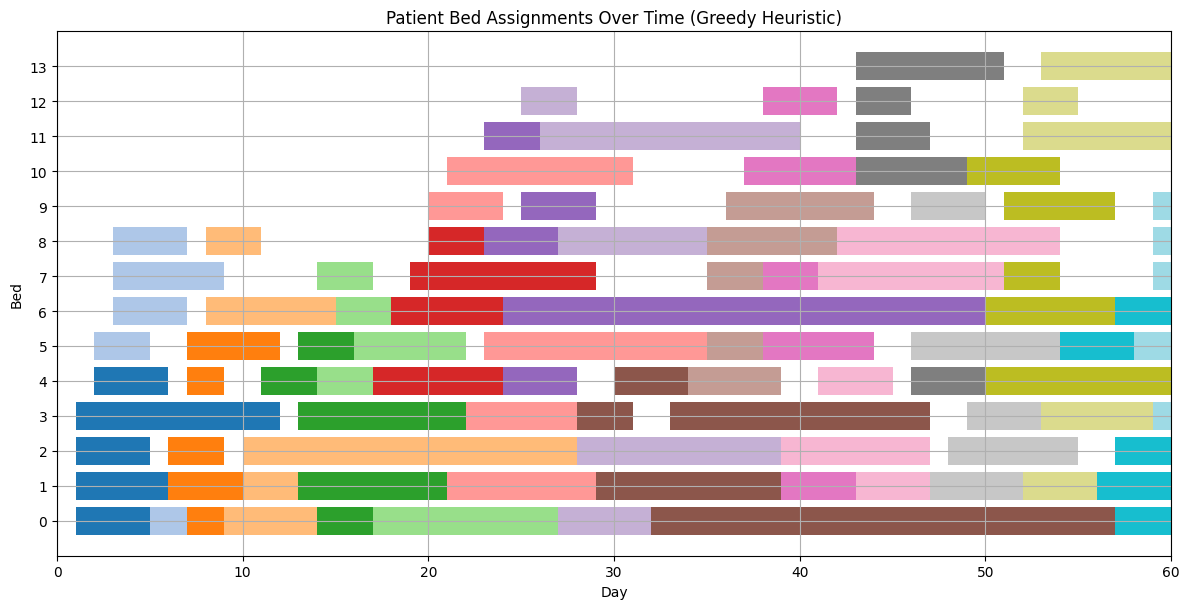

In [7]:
fig, ax = plt.subplots(figsize=(12, len(valid_assignments["bed_id"].unique()) * 0.3 + 2))
colors = plt.cm.get_cmap("tab20", len(valid_assignments))

for i, (_, row) in enumerate(valid_assignments.iterrows()):
    bed = row["bed_id"]
    start = row["start"]
    end = row["end"]
    ax.broken_barh([(start, end - start)], (bed - 0.4, 0.8), facecolors=colors(i))

ax.set_xlabel("Day")
ax.set_ylabel("Bed")
ax.set_title("Patient Bed Assignments Over Time (Greedy Heuristic)")
ax.set_xlim(0, simulation_days)
ax.set_ylim(-1, valid_assignments["bed_id"].max() + 1)
ax.set_yticks(range(valid_assignments["bed_id"].max() + 1))
ax.grid(True)
plt.tight_layout()
plt.show()

## Summary of Results

- **Number of patients simulated:** 100
- **Number of beds used:** 14
- **Simulation days:** 60  

This heuristic provides a fast and interpretable solution. It can be used as a baseline for comparing more advanced metaheuristic or MILP-based solutions.



## Performance Benchmark of the Greedy Heuristic Algorithm

This section evaluates how well the greedy bed assignment algorithm performs under different patient load scenarios. We measure:

- **Beds Used**: Number of hospital beds utilized.
- **Idle Time (%)**: The percentage of time that allocated beds remain unused.
- **Runtime (s)**: Time taken to complete the assignment for a given batch size.

The table summarizes the results for different batch sizes, and final graphs are shown for the 500-patient scenario.

In [11]:
# Define patient batch sizes
sample_sizes = [20, 50, 100, 200, 500]
simulation_days = 60
n_beds = 100
results = []

max_patients = len(df_full)

for n_patients in sample_sizes:
    if n_patients > max_patients:
        continue

    np.random.seed(42)
    new_patients = df_full.sample(n=n_patients, random_state=123).copy()
    new_patients['day_of_admission'] = np.random.randint(0, simulation_days, size=n_patients)
    new_patients['predicted_los'] = np.ceil(np.random.randint(2, 10, size=n_patients)).astype(int)

    beds = defaultdict(list)
    assignments = []
    patients_sorted = new_patients.sort_values(by='day_of_admission')

    start_time = time.time()

    for idx, patient in patients_sorted.iterrows():
        assigned = False
        start = int(patient['day_of_admission'])
        end = int(min(start + patient['predicted_los'], simulation_days))

        for bed_id in range(n_beds):
            overlaps = any(not (end <= s or start >= e) for s, e in beds[bed_id])
            if not overlaps:
                beds[bed_id].append((start, end))
                assignments.append({
                    'patient_id': idx,
                    'bed_id': bed_id,
                    'start': start,
                    'end': end
                })
                assigned = True
                break

        if not assigned:
            assignments.append({
                'patient_id': idx,
                'bed_id': None,
                'start': start,
                'end': end
            })

    elapsed = time.time() - start_time

    assignments_df = pd.DataFrame(assignments)
    used_assignments = assignments_df.dropna(subset=["bed_id"]).copy()
    used_assignments["bed_id"] = used_assignments["bed_id"].astype(int)
    beds_used = used_assignments["bed_id"].nunique()

    idle_time = 0
    total_time = beds_used * simulation_days
    for bed_id in range(beds_used):
        schedule = sorted(beds[bed_id])
        for i in range(len(schedule)):
            if i == 0:
                idle_time += schedule[i][0]
            else:
                idle_time += max(0, schedule[i][0] - schedule[i-1][1])
            if i == len(schedule) - 1:
                idle_time += max(0, simulation_days - schedule[i][1])

    idle_percent = (idle_time / total_time) * 100 if total_time > 0 else 0

    results.append({
        "Patients": n_patients,
        "Beds Used": beds_used,
        "Idle Time (%)": round(idle_percent, 2),
        "Runtime (s)": round(elapsed, 4)
    })

# Convert to DataFrame
benchmark_df = pd.DataFrame(results)

display(benchmark_df)

# Filter for 500-patient case
assignments_df_500 = assignments_df if n_patients == 500 else None


,Patients,Beds Used,Idle Time (%),Runtime (s)
0,20,5,67.33,0.0006
1,50,7,42.86,0.0010
2,100,14,37.14,0.0027
3,200,26,35.64,0.0055
4,500,57,24.74,0.0141


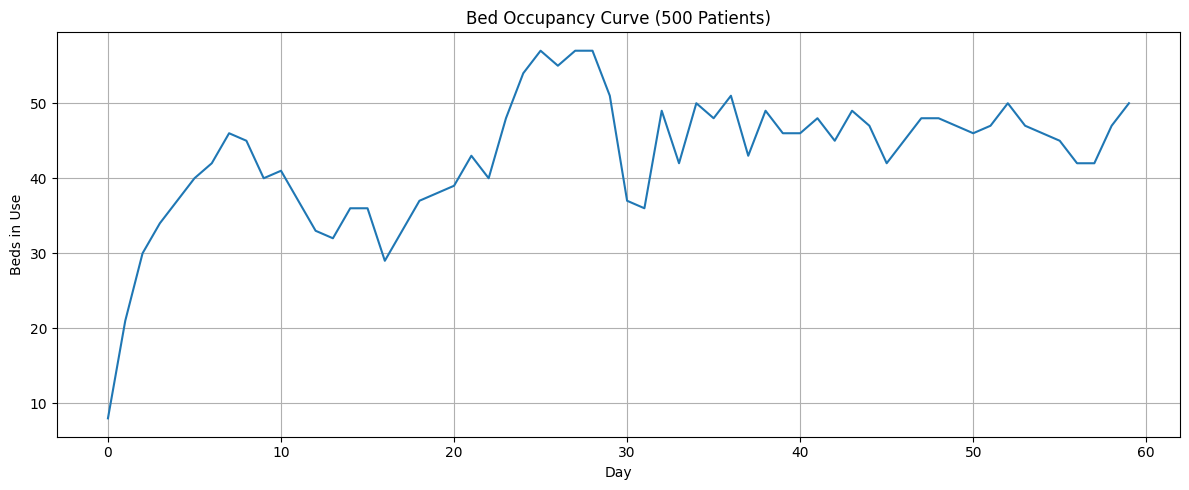

C:\Users\Angel Rojas\AppData\Local\Temp\ipykernel_71460\1749667935.py:22: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = cm.get_cmap("tab20", len(valid_assignments))


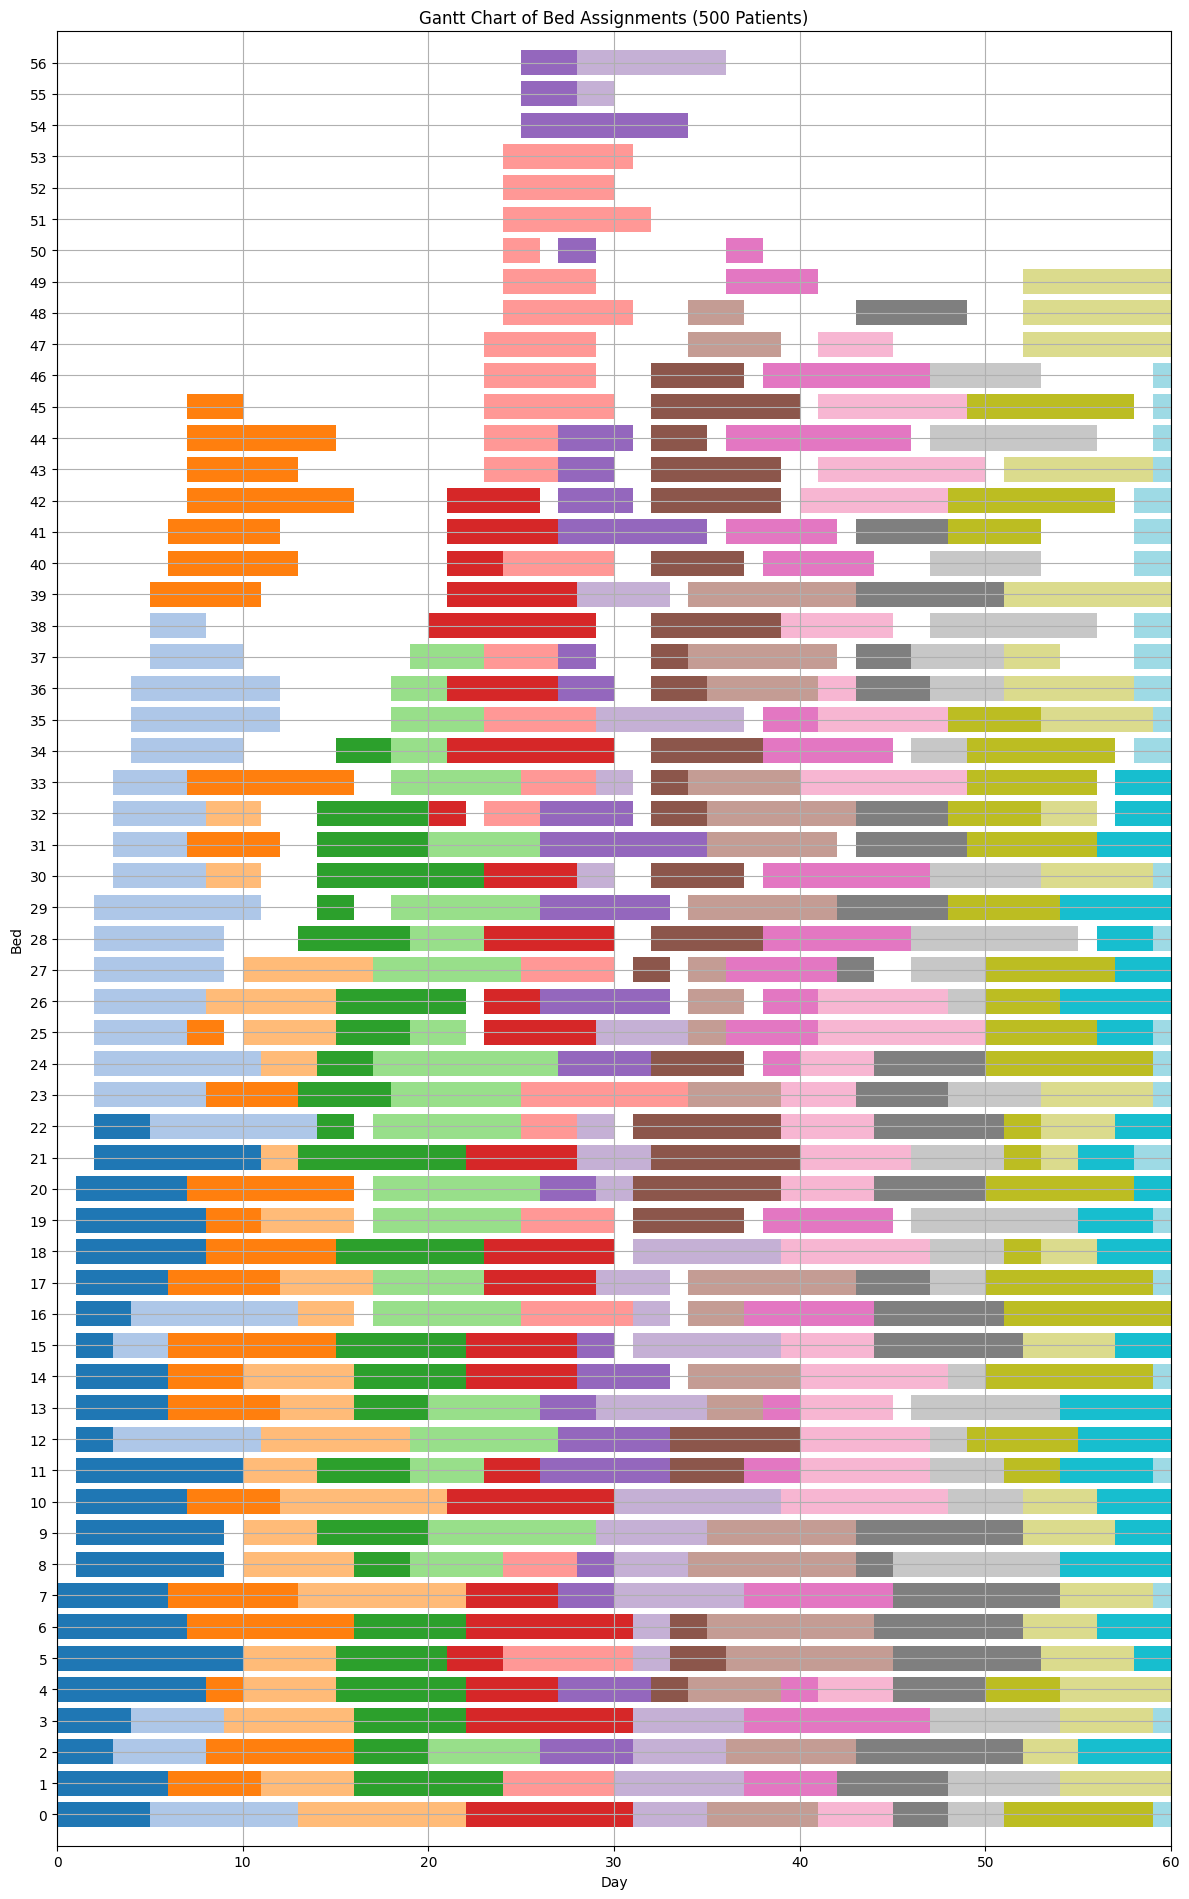

In [13]:
# Plot occupancy curve
bed_occupancy = np.zeros(simulation_days)
for _, row in assignments_df_500.dropna().iterrows():
    start = int(row['start'])
    end = int(row['end'])
    bed_occupancy[start:end] += 1

plt.figure(figsize=(12, 5))
plt.plot(bed_occupancy)
plt.title("Bed Occupancy Curve (500 Patients)")
plt.xlabel("Day")
plt.ylabel("Beds in Use")
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot Gantt chart of assignments
valid_assignments = assignments_df_500.dropna(subset=["bed_id"]).copy()
valid_assignments["bed_id"] = valid_assignments["bed_id"].astype(int)

fig, ax = plt.subplots(figsize=(12, len(valid_assignments["bed_id"].unique()) * 0.3 + 2))
colors = cm.get_cmap("tab20", len(valid_assignments))

for i, (_, row) in enumerate(valid_assignments.iterrows()):
    bed = row["bed_id"]
    start = int(row["start"])
    end = int(row["end"])
    ax.broken_barh([(start, end - start)], (bed - 0.4, 0.8), facecolors=colors(i))

ax.set_xlabel("Day")
ax.set_ylabel("Bed")
ax.set_title("Gantt Chart of Bed Assignments (500 Patients)")
ax.set_xlim(0, simulation_days)
ax.set_ylim(-1, valid_assignments["bed_id"].max() + 1)
ax.set_yticks(range(valid_assignments["bed_id"].max() + 1))
ax.grid(True)
plt.tight_layout()
plt.show()

## Future Work

- Integrate patient priority levels or medical constraints
- Compare with metaheuristic approaches (e.g., genetic algorithms)
- Add cost modeling for underutilization and overcapacity
